In [1]:
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.optimize

pd.options.display.max_rows = 350

In [2]:
# needs to be in a separate cell, see https://github.com/ipython/ipython/issues/11098
mpl.rcParams['figure.dpi'] = 100
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
if os.path.exists('extern'):
    PREFIX = 'extern/COVID-19/csse_covid_19_data'
else:
    PREFIX = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data'

In [4]:
populations = (
    pd.read_csv(f'{PREFIX}/UID_ISO_FIPS_LookUp_Table.csv')
    .rename(columns=lambda x: x.replace('_', '/'))
    .convert_dtypes()
    .fillna({'Province/State': ''})
    .groupby(['Country/Region', 'Province/State'])
    .sum()
    ['Population']
    .loc()[lambda x: x > 0]
)

In [5]:
all_data = {
    loc: pd.concat({
        'cases': pd.read_csv(f'{PREFIX}/csse_covid_19_time_series/time_series_covid19_confirmed_{loc}.csv'),
        'deaths': pd.read_csv(f'{PREFIX}/csse_covid_19_time_series/time_series_covid19_deaths_{loc}.csv'),
    }, names=['values'])
    .droplevel(1)
    .convert_dtypes()
    .rename(columns=lambda x: x.replace('_', '/'))
    .fillna({'Province/State': ''})
    for loc in ['US', 'global']
}
all_data = (
    pd.concat([
        all_data['US']
        .groupby(['values', 'Country/Region', 'Province/State']).sum()
        .iloc(1)[5:-1],
        all_data['global']
        .set_index(['Country/Region', 'Province/State'], append=True)
        .iloc(1)[2:]
    ])
    .sort_index()
    .fillna({'Province/State': ''})
    .rename_axis(columns='day')
    .stack()
    .unstack(0)
    .reset_index('day')
    .assign(day=lambda x: pd.to_datetime(x['day']))
    .set_index('day', append=True)
    .join(populations, how='inner')
    .pipe(lambda df: df.apply(lambda x: x / df['Population'] * 1e6))
    .drop(columns='Population')
    .drop(index=('US', ''))
    .groupby(['Country/Region', 'Province/State'], group_keys=False).apply(
        lambda df: pd.concat(
            [df, df.diff().rolling(7).sum()], keys=['total', 'delta'], axis=1
        ).iloc()[7:]
    )
    .reorder_levels([1, 0], axis=1)
    .sort_index(axis=1)
)
all_data

cases           deaths          
                                             delta     total  delta     total
Country/Region Province/State day                                            
Afghanistan                   2020-01-29  0.000000  0.000000    0.0  0.000000
                              2020-01-30  0.000000  0.000000    0.0  0.000000
                              2020-01-31  0.000000  0.000000    0.0  0.000000
                              2020-02-01  0.000000  0.000000    0.0  0.000000
                              2020-02-02  0.000000  0.000000    0.0  0.000000
...                                            ...       ...    ...       ...
Zimbabwe                      2020-04-16  0.807378  1.547474    0.0  0.201844
                              2020-04-17  0.740096  1.614756    0.0  0.201844
                              2020-04-18  0.740096  1.682037    0.0  0.201844
                              2020-04-19  0.740096  1.682037    0.0  0.201844
                              2020-04-20  0.538252  1.682037    0.0  0.201844

[26062 rows x 4 columns]

In [6]:
max_values = (
    all_data
    .stack([-2, -1])
    .unstack('day')
    .max(axis=1)
    .unstack([-2, -1])
    .join(pd.concat([populations], keys=[('population', 'total')], axis=1))
    .loc()[lambda x: x['population', 'total'] > 2e5]
    .drop(columns=('population', 'total'))
    .apply(
        lambda x: x.sort_values(ascending=False).iloc[:30]
    )
    .groupby('Country/Region', group_keys=False).apply(
        lambda x: x.sort_values(('cases', 'total'), ascending=False).iloc()[:5]
    )
)

In [7]:
query = all_data.unstack().loc()[
    list(max_values.index) + [('Czechia', ''), ('Slovakia', '')]
].stack().sort_index()

In [8]:
def f(x, a):
    return a * x


def find_cfr(df):
    cases = df['cases', 'delta']
    if len(cases) < 20:
        return
    deaths = df['deaths', 'delta']
    fits = []
    for n in range(5, 15):
        param, err = scipy.optimize.curve_fit(f, cases[:-n], deaths.shift(-n)[:-n])
        if param[0] <= 0:
            return
        fits.append((n, 100 * param[0], 100 * np.sqrt(np.diag(err)[0])/param[0]))
    fits = pd.DataFrame(fits, columns=['shift', 'CFR', 'confidence'])
#     return fits.loc()[fits['confidence'].idxmin()]
    return fits.loc()[5]
    

(
    query
    .groupby(['Country/Region', 'Province/State'])
    .apply(find_cfr)
    .loc()[lambda x: x['confidence'] < 5]
    .sort_values('CFR')
)

,5,shift,CFR,confidence
Country/Region,Province/State,,,
Israel,,10.0,1.510680,2.498780
Luxembourg,,10.0,2.070725,4.377083
Norway,,10.0,2.774537,3.448016
Austria,,10.0,3.080962,3.076394
Czechia,,10.0,3.514511,1.350666
Germany,,10.0,3.873713,1.612477
Portugal,,10.0,4.410532,3.359998
Switzerland,,10.0,5.594741,1.140723
Canada,Quebec,10.0,7.573111,2.527833


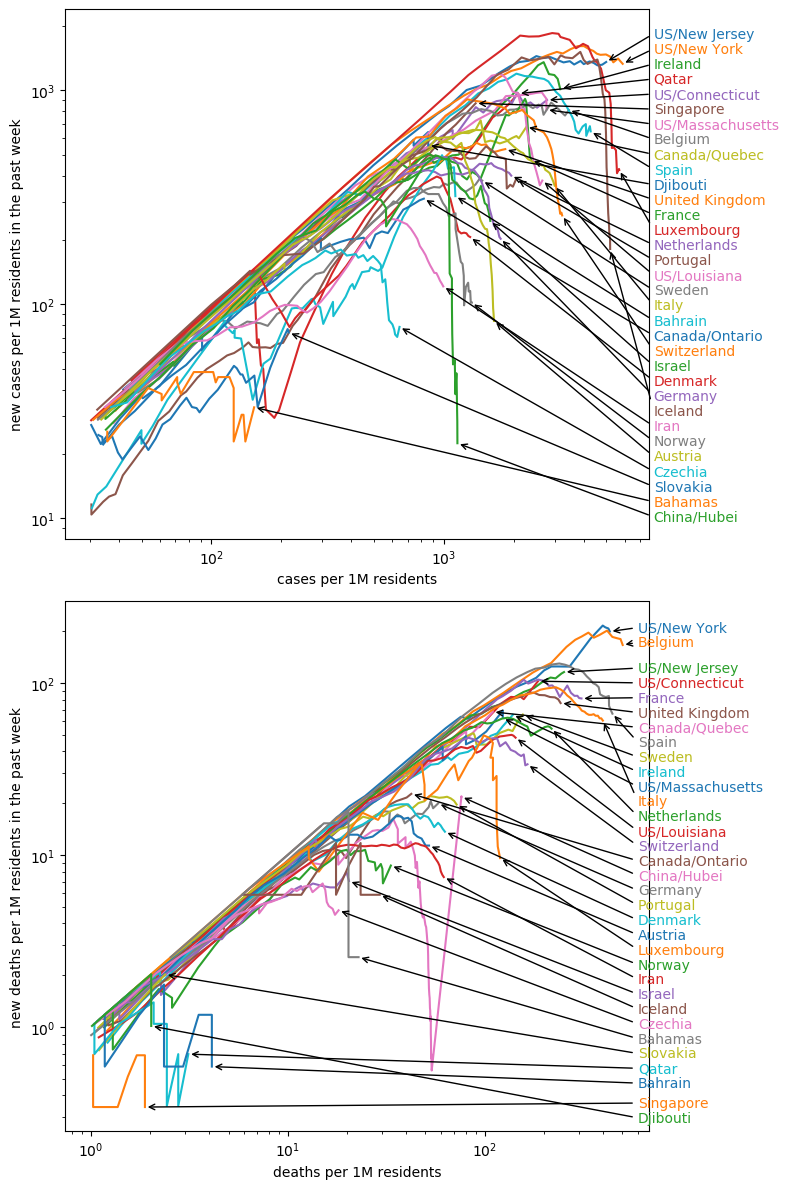

In [9]:
fig, axes = plt.subplots(2, 1, figsize=(8, 12))
params = [
    ('cases', axes[0], 8_000, 1.3, 30, 0.85),
    ('deaths', axes[1], 600, 1, 1, 0.82)
]
for kind, ax, edge, start, thre, step in params:
    payload = sorted(
        query[kind].groupby(['Country/Region', 'Province/State']),
        key=lambda x: x[1].iloc()[-1]['delta'],
        reverse=True
    )
    prev_y_annot = np.inf
    for i, (key, df_i) in enumerate(payload):
        label = '/'.join(key) if key[1] else key[0]
        color = COLORS[i % len(COLORS)]
        df_i = df_i.loc()[lambda x: x['total'] >= thre]
        df_i = df_i.loc()[lambda x: x['delta'] >= 0.3 * x['delta'][0]]
        df_i.plot('total', 'delta', ax=ax, label=label, c=color)
        if not len(df_i):
            continue
        last_i = df_i.iloc()[-1]
        prev_y_annot = min(start * last_i['delta'], step * prev_y_annot)
        ax.annotate(
            label,
            (last_i['total'], last_i['delta']),
            xytext=(edge, prev_y_annot),
            color=color,
            arrowprops={
                'arrowstyle': '->',
                'relpos': (0, 0.5),
            },
        )
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(f'{kind} per 1M residents')
    ax.set_ylabel(f'new {kind} per 1M residents in the past week')
    ax.get_legend().remove()
fig.tight_layout()

In [10]:
fig.savefig('figure.svg')